In [445]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
import json
import shap
from joblib import load
import warnings
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches
from matplotlib.collections import PolyCollection

warnings.filterwarnings("ignore", category=UserWarning)


In [446]:
modelfolder = r"PMF_Day_Breach_HGBR\\"
outputfolder = r'PMF_Day_Breach_HGBR\\'
name_convention = "HGBR_PMF_Day_Breach_5CombinedIte"

In [447]:
best_model = load(f'{modelfolder}{name_convention}_best_model.joblib')
X_train = load(f'{modelfolder}{name_convention}_X_train.joblib')
y_train = load(f'{modelfolder}{name_convention}_y_train.joblib')
X_test = load(f'{modelfolder}{name_convention}_X_test.joblib')
y_test = load(f'{modelfolder}{name_convention}_y_test.joblib')
feature_cols = load(f'{modelfolder}{name_convention}_feature_col_lst.joblib')
numerical_cols = load(f'{modelfolder}{name_convention}_numerical_col_lst.joblib')
categorical_cols = load(f'{modelfolder}{name_convention}_categorical_col_lst.joblib')

with open(f'{modelfolder}{name_convention}_kf_config.json', 'r') as f:
    kf_config_loaded = json.load(f)
kf = KFold(**kf_config_loaded)

In [450]:
size=2000

In [451]:
# transform the training set for SHAP analysis
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_cols),
    # 'passthrough' for categorical features if no preprocessing is needed
    ('cat', 'passthrough', categorical_cols)
    ])

# set up the pipeline
transformer_pipeline = Pipeline([('preprocessor', preprocessor)])

X_train_transformed = transformer_pipeline.fit_transform(X_train)
        
# extract feature names after transformation
feature_names_transformed = list(transformer_pipeline.named_steps['preprocessor'].get_feature_names_out())
        
# sample training data from shap
X_sample = shap.sample(X_train_transformed, size)

# initialize SHAP KernelExplainer using the best model
final_model = best_model.named_steps['gbr']
explainer = shap.KernelExplainer(model=final_model.predict, data=X_sample, link="identity")

# calculate SHAP values for a subset of the test set
shap_values = explainer.shap_values(X=X_sample)

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 2000/2000 [7:39:52<00:00, 13.80s/it]  


In [453]:
feature_names_transformed

['num__PopU65',
 'num__PopO65',
 'num__TimeWarned',
 'num__TimeMobilized',
 'num__Structure_Number_of_Stories',
 'num__Fording_Depth',
 'num__Max_Depth',
 'num__Max_Velocity',
 'num__Max_DxV',
 'num__Time_To_First_Wet',
 'cat__Warned',
 'cat__Mobilized',
 'cat__Structure_Stability_Criteria',
 'cat__Vehicle_Type']

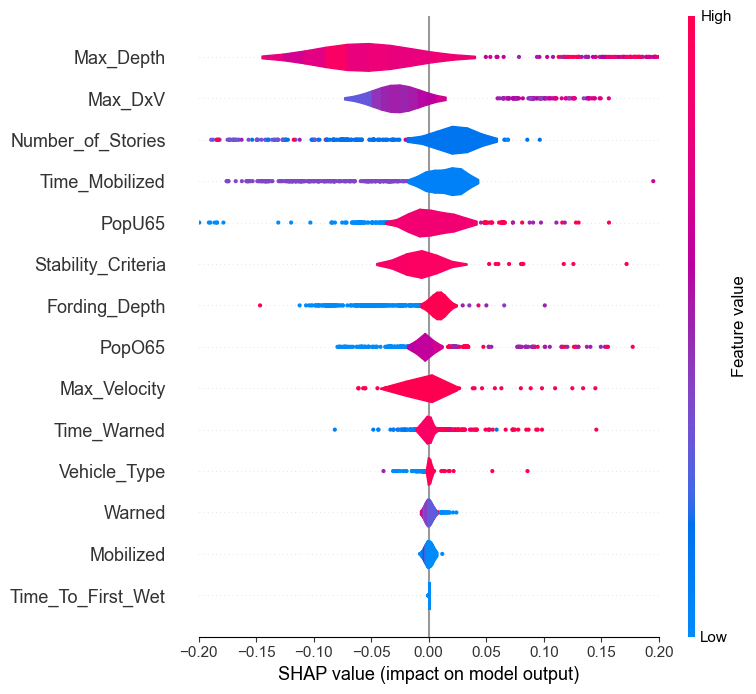

In [464]:
feature_name_mapping = {'num__PopU65': 'PopU65',
 'num__PopO65': 'PopO65',
 'num__TimeWarned': 'Time_Warned',
 'num__TimeMobilized':  'Time_Mobilized',
 'num__Structure_Number_of_Stories': 'Number_of_Stories',
 'num__Fording_Depth':'Fording_Depth',
 'num__Max_Depth': 'Max_Depth',
 'num__Max_Velocity':  'Max_Velocity',
 'num__Max_DxV': 'Max_DxV',
 'num__Time_To_First_Wet': 'Time_To_First_Wet',
 'cat__Warned': 'Warned',
 'cat__Mobilized': 'Mobilized',
 'cat__Structure_Stability_Criteria': 'Stability_Criteria',
 'cat__Vehicle_Type': 'Vehicle_Type',
 }

new_feature_names = [feature_name_mapping.get(name, name) for name in feature_names_transformed]

shap.summary_plot(
        shap_values, 
        X_sample, 
        feature_names = new_feature_names,
        # max_display = 10,
        sort = True,
        show = False,
        plot_type='violin' 
        )

plt.xlim(-0.2, 0.2)

x_ticks = [-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2]
plt.xticks(ticks=x_ticks)

plt.tight_layout()  
plt.show()

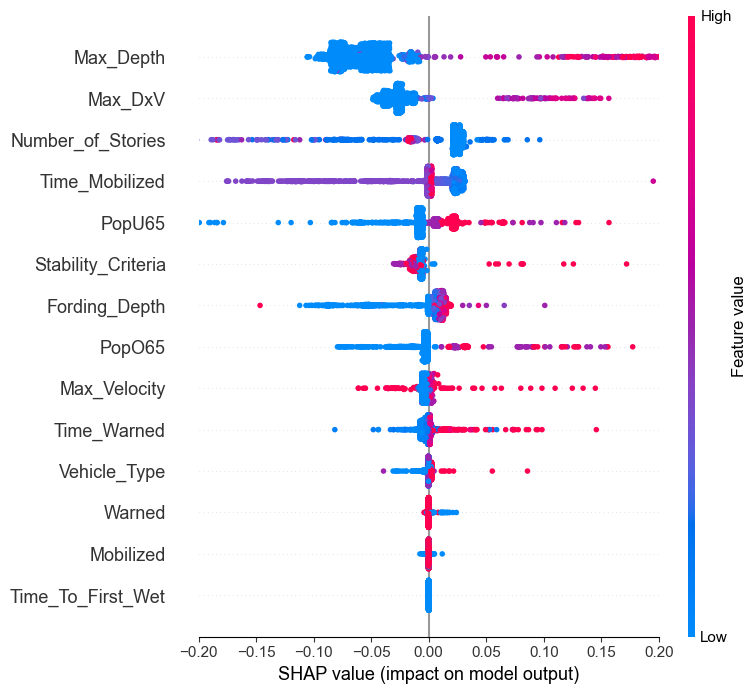

In [465]:
shap.summary_plot(
        shap_values, 
        X_sample, 
        feature_names = new_feature_names,
        # max_display = 10,
        sort = True,
        show = False,
        )

plt.xlim(-0.2, 0.2)

x_ticks = [-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2]
plt.xticks(ticks=x_ticks)

plt.tight_layout()  
plt.show()

In [455]:
shap_values_explanation = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value, 
    data=X_sample, 
    feature_names=new_feature_names
    )

expected_value = explainer.expected_value

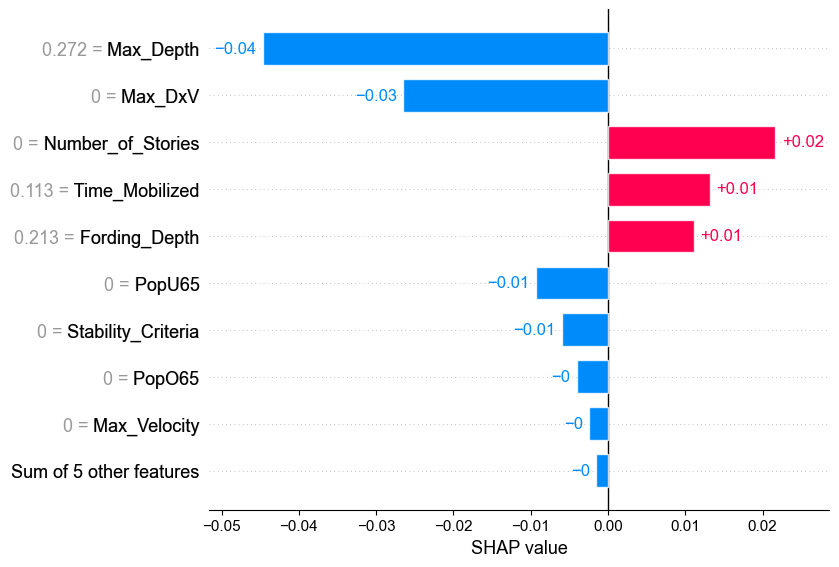

In [467]:
shap.plots.bar(shap_values_explanation[0], show=False)

plt.show()

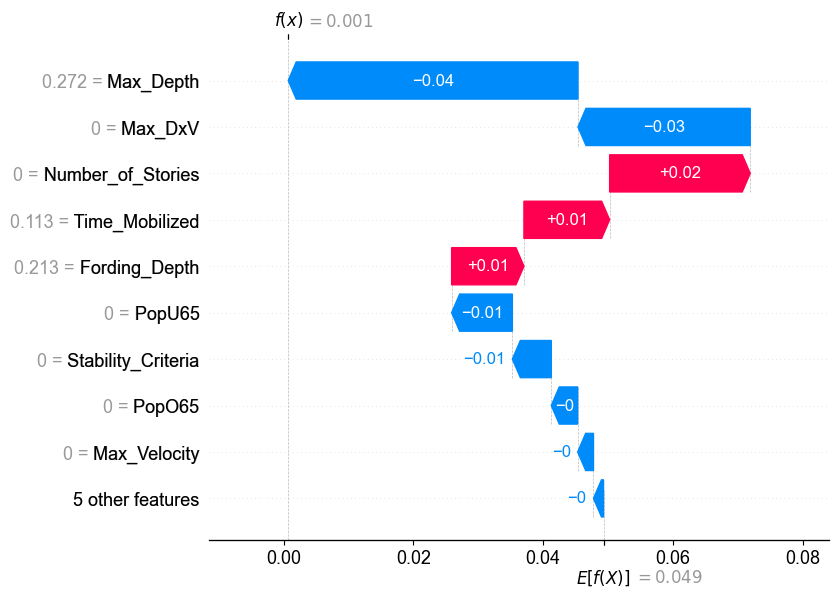

In [468]:
shap.plots.waterfall(shap_values_explanation[0], show=False)

plt.show()

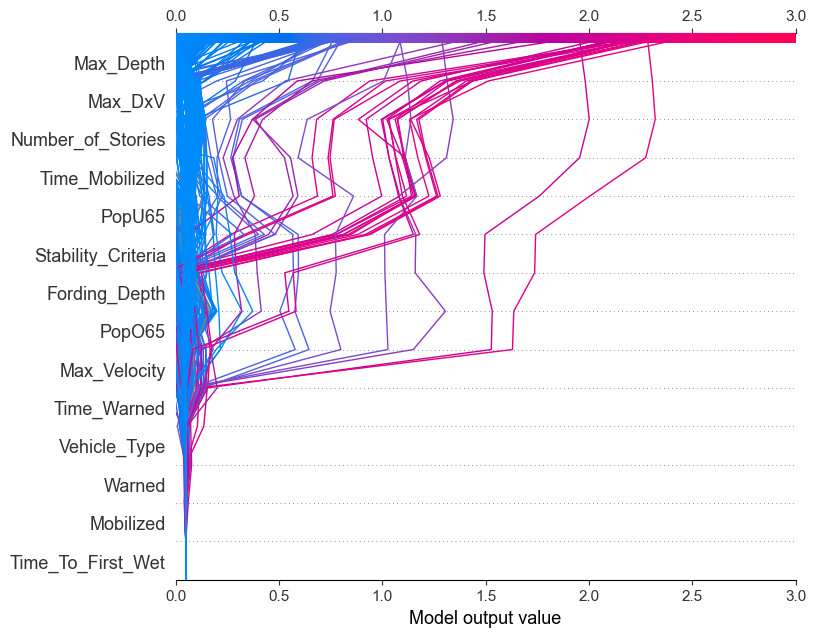

In [459]:
shap.decision_plot(expected_value, shap_values, new_feature_names, xlim =(0,3), show=False)

plt.show()

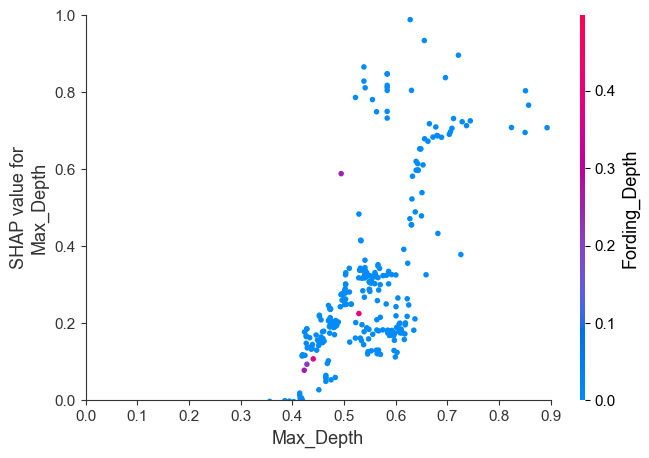

In [472]:
dependent_plot = shap.dependence_plot("Max_Depth", shap_values, X_sample, new_feature_names, interaction_index="Fording_Depth", show=False,
                                      xmin = 0, xmax = 0.9, ymin = 0, ymax = 1)

plt.show()

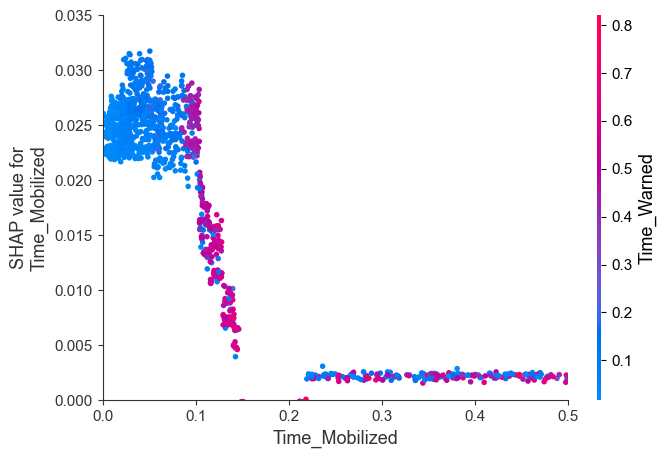

In [462]:
dependent_plot = shap.dependence_plot("Time_Mobilized", shap_values, X_sample, new_feature_names, interaction_index="Time_Warned", show=False,
                                      xmin = 0, xmax = 0.5, ymin = 0, ymax = 0.035)

plt.show()